My reference documents:
- https://wfdb.readthedocs.io/en/latest/wfdb.html
- https://wfdb.readthedocs.io/en/latest/processing.html
- https://github.com/rohitdwivedula/ecg_benchmarking

In [ ]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

import wfdb
from wfdb import processing

In [2]:
def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    rr = wfdb.processing.calc_rr(qrs_locs=peak_inds, fs=fs)
    mean_hrs = wfdb.processing.calc_mean_hr(rr=rr, fs=fs)

    title += f"\n Mean Heart Rate = {mean_hrs:.2f}"

    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()


In [3]:
def load_raw_data(df, sampling_rate, path):
    
    if sampling_rate == 100:
        data = [wfdb.rdrecord(path+f) for f in df.filename_lr]
        anno = [wfdb.rdann(path+f, 'dat', sampfrom=0, sampto=1000, shift_samps=True) for f in df.filename_lr]
    else:
        data = [wfdb.rdrecord(path+f) for f in df.filename_hr]
        anno = [wfdb.rdann(path+f, 'dat', sampfrom=0, sampto=5000, shift_samps=True) for f in df.filename_hr]
    return data, anno

In [4]:

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [5]:
path = 'data/physionet.org/files/ptb-xl/1.0.2/'
sampling_rate = 500

Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
Y = Y.iloc[:5]
Y

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,SLI-LVH,QRS-CLBB,ST-ELEV-MI,ST-DEPR-MI,Q-ISC,Q-ISC-QPeak,Q-ISC-V2V3,Q-ISC-RPeak,STRAIN,MI-ALL
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,False,False,False,False,False,False,False,False,False,False
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,False,False,False,False,False,False,False,False,False
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,False
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,False
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,False


In [6]:
# Read a WFDB record and annotation. 
records, annotations = load_raw_data(Y, sampling_rate, path)

In [7]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,QRS-CLBB,ST-ELEV-MI,ST-DEPR-MI,Q-ISC,Q-ISC-QPeak,Q-ISC-V2V3,Q-ISC-RPeak,STRAIN,MI-ALL,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,False,False,False,False,False,False,False,False,False,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]


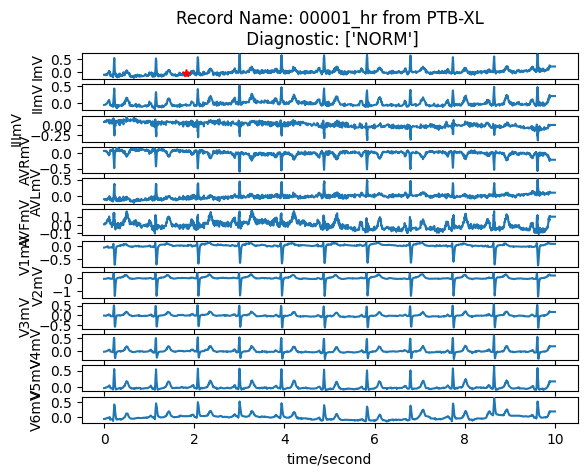

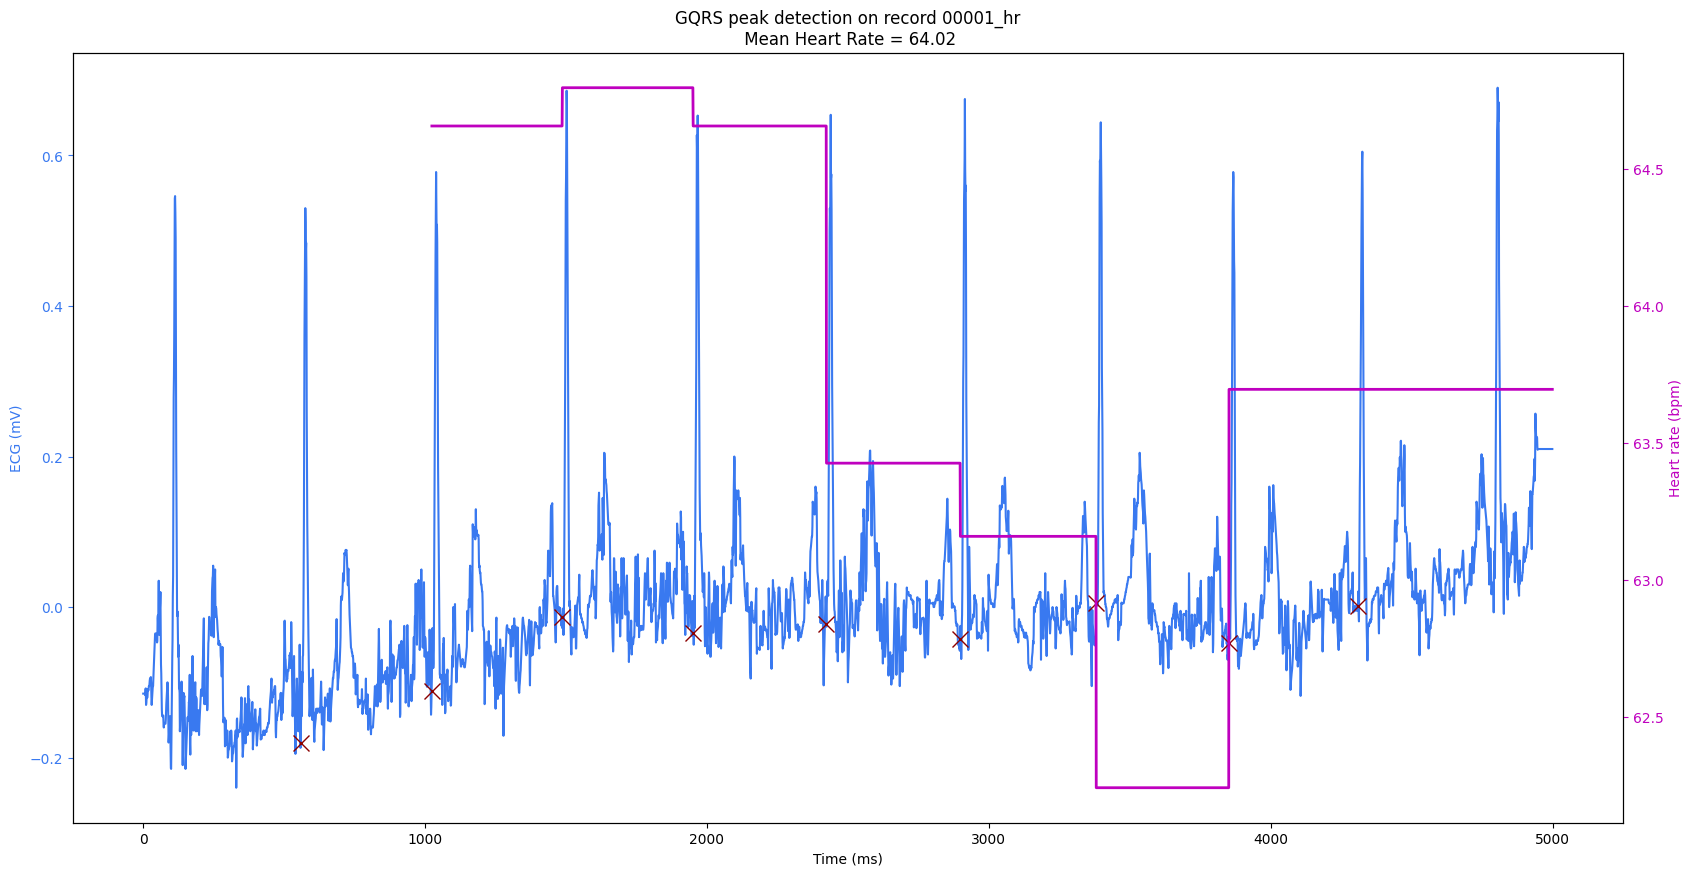

Corrected GQRS detected peak indices: [575, 1039, 1502, 1967, 2439, 2915, 3397, 3867, 4325]


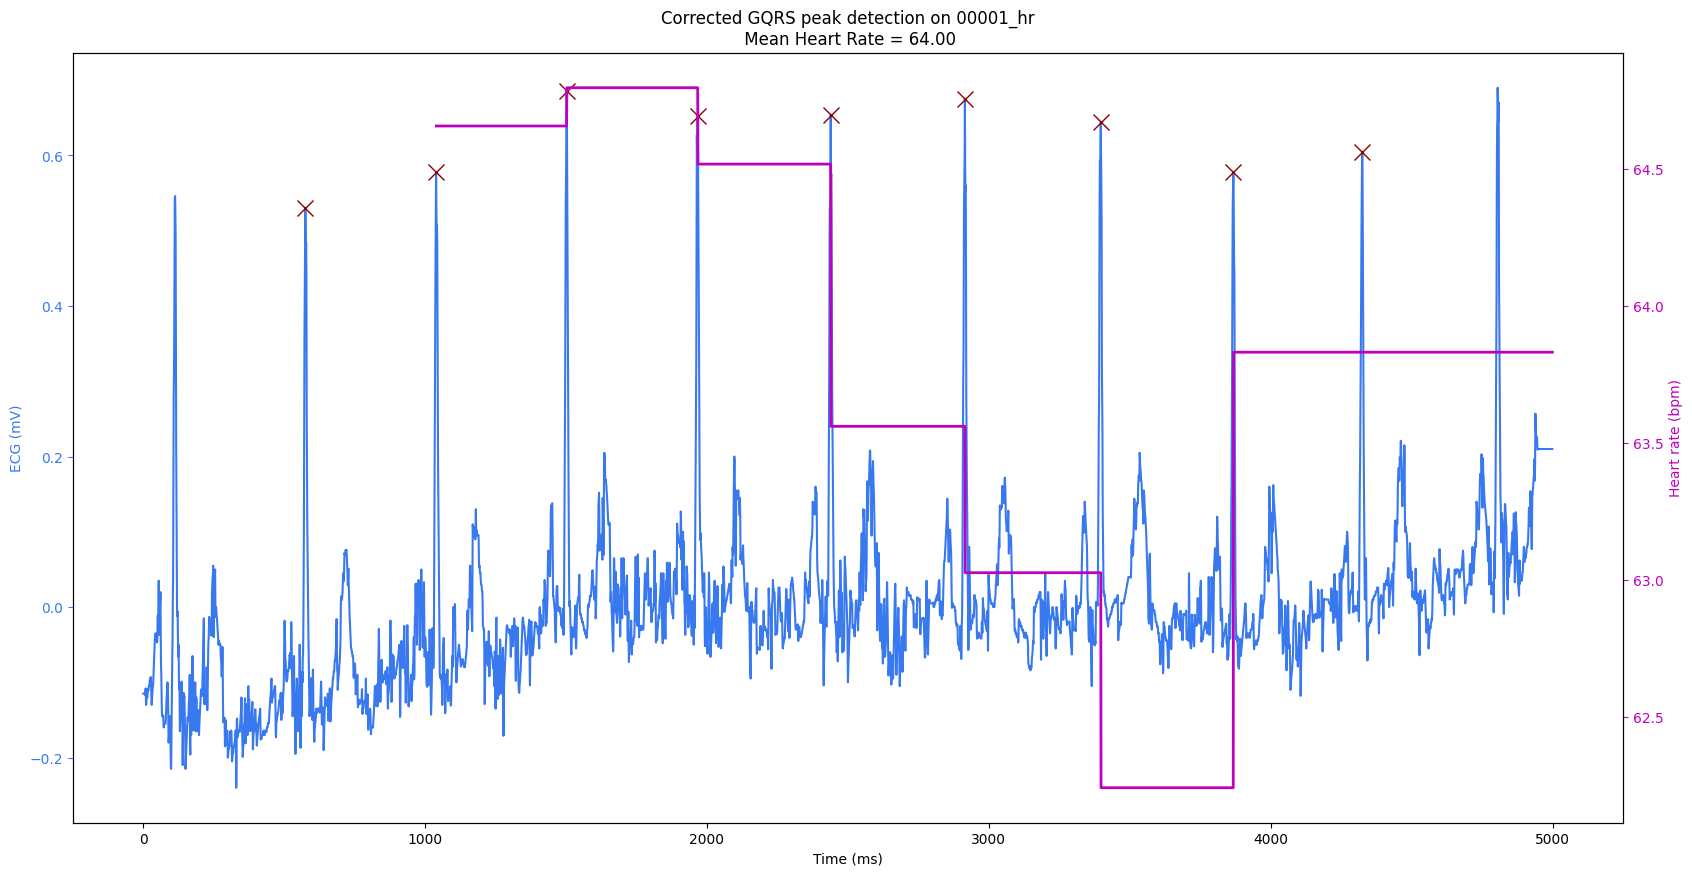

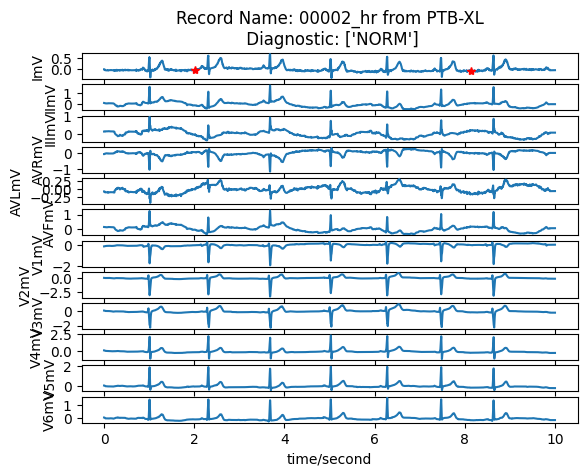

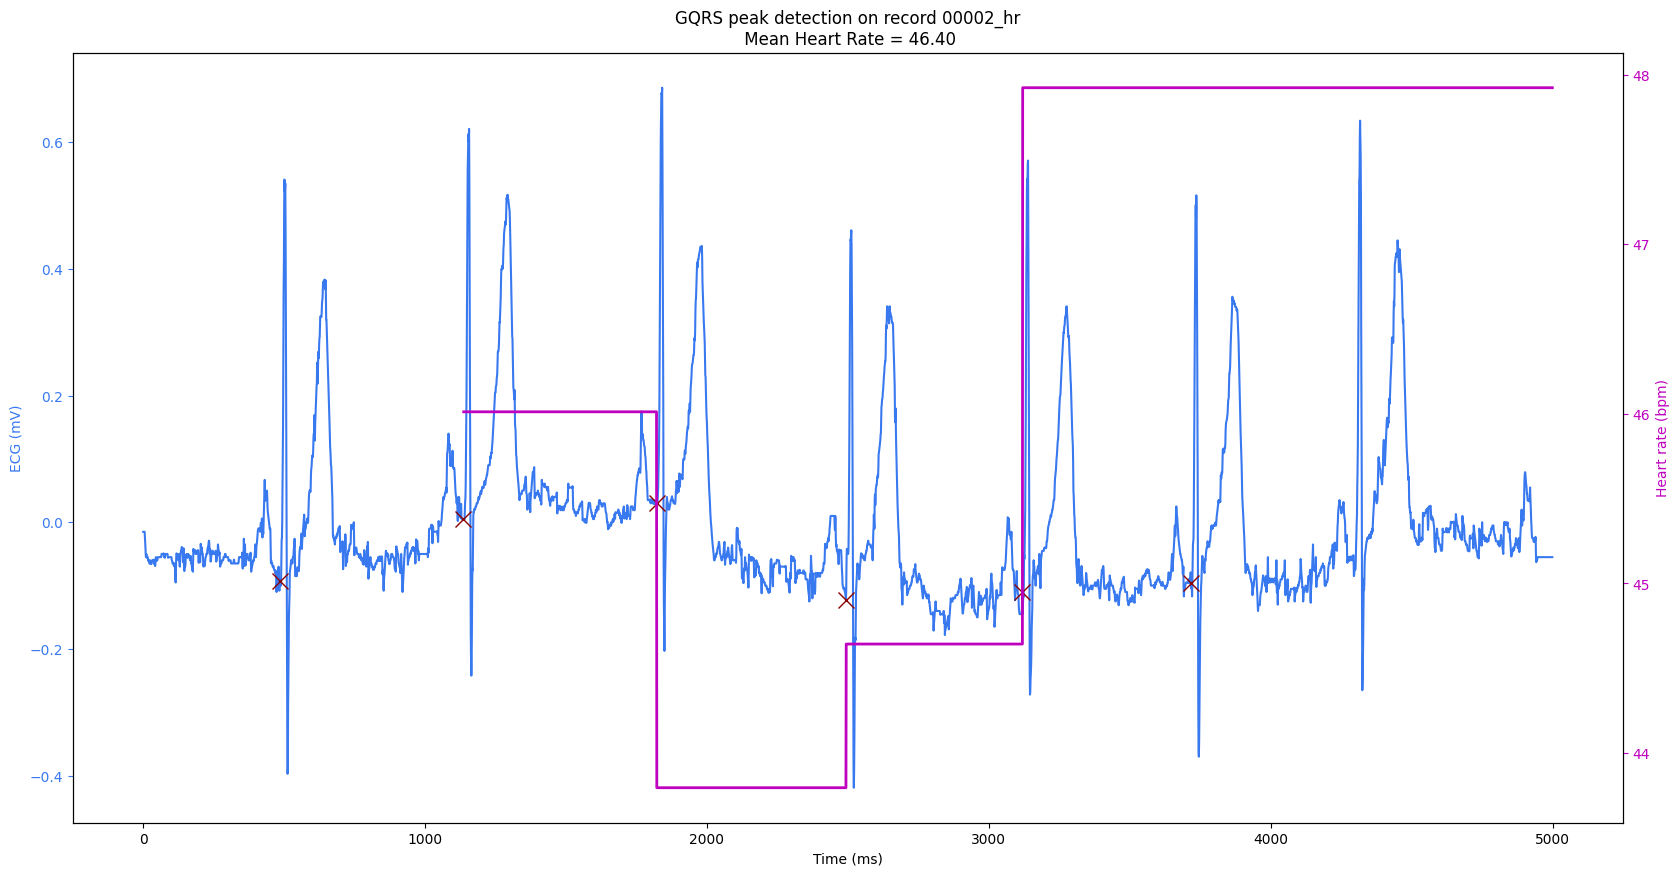

Corrected GQRS detected peak indices: [501, 1156, 1841, 2512, 3139, 3736]


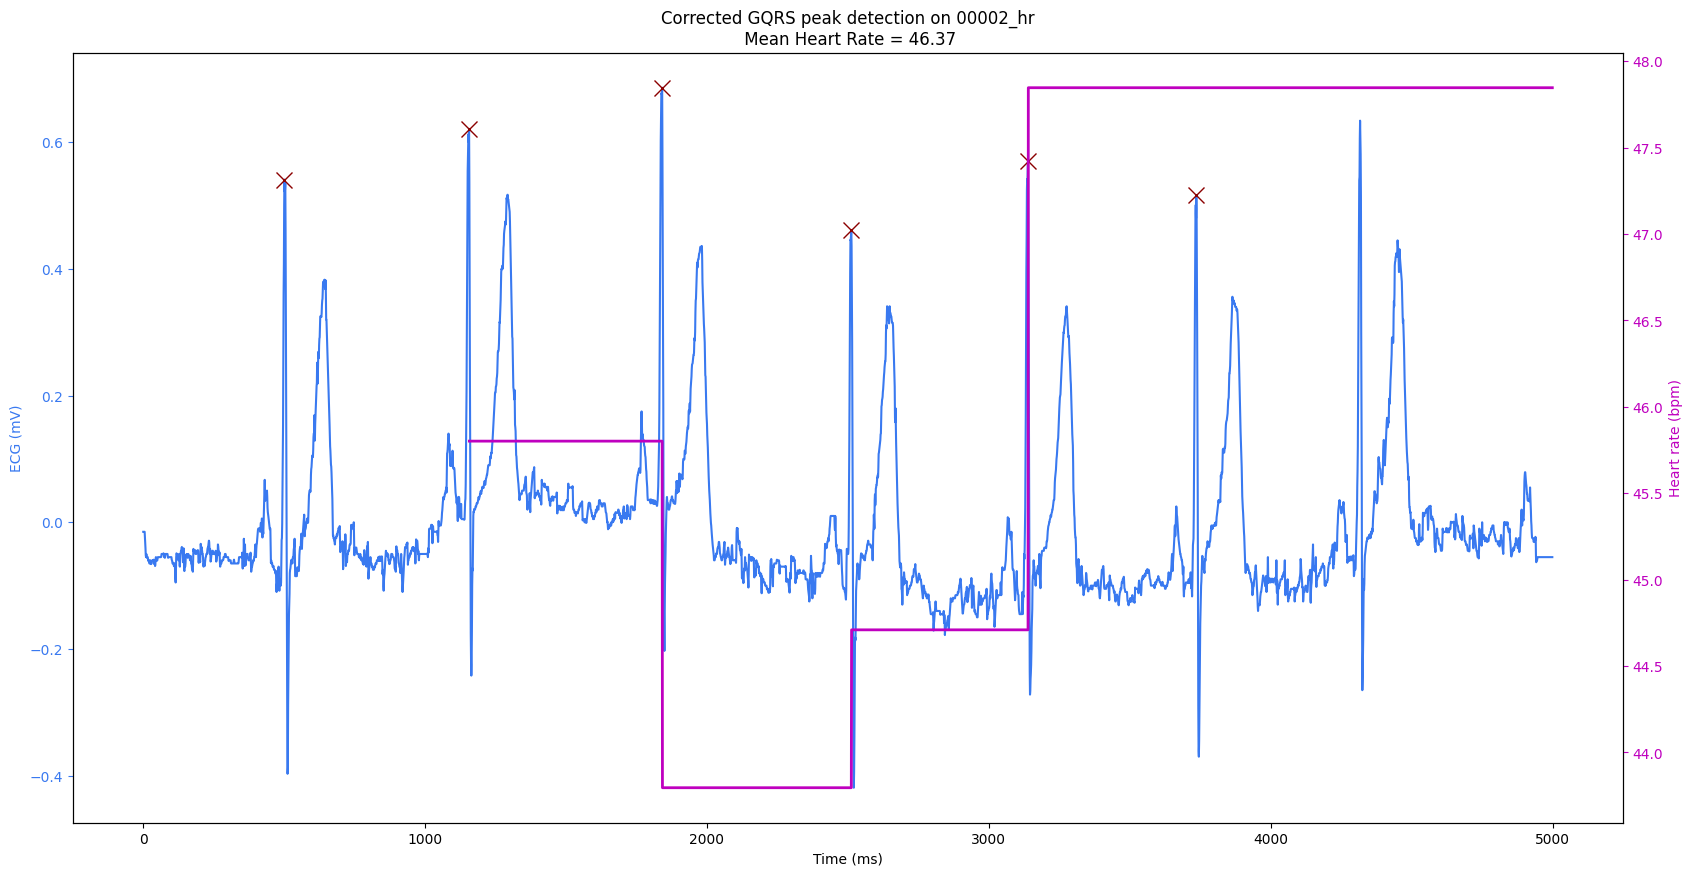

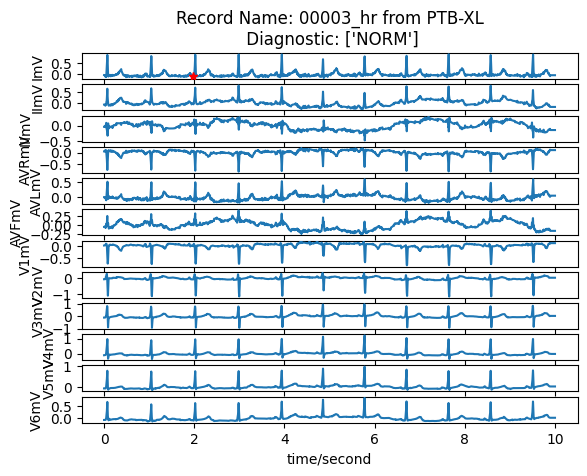

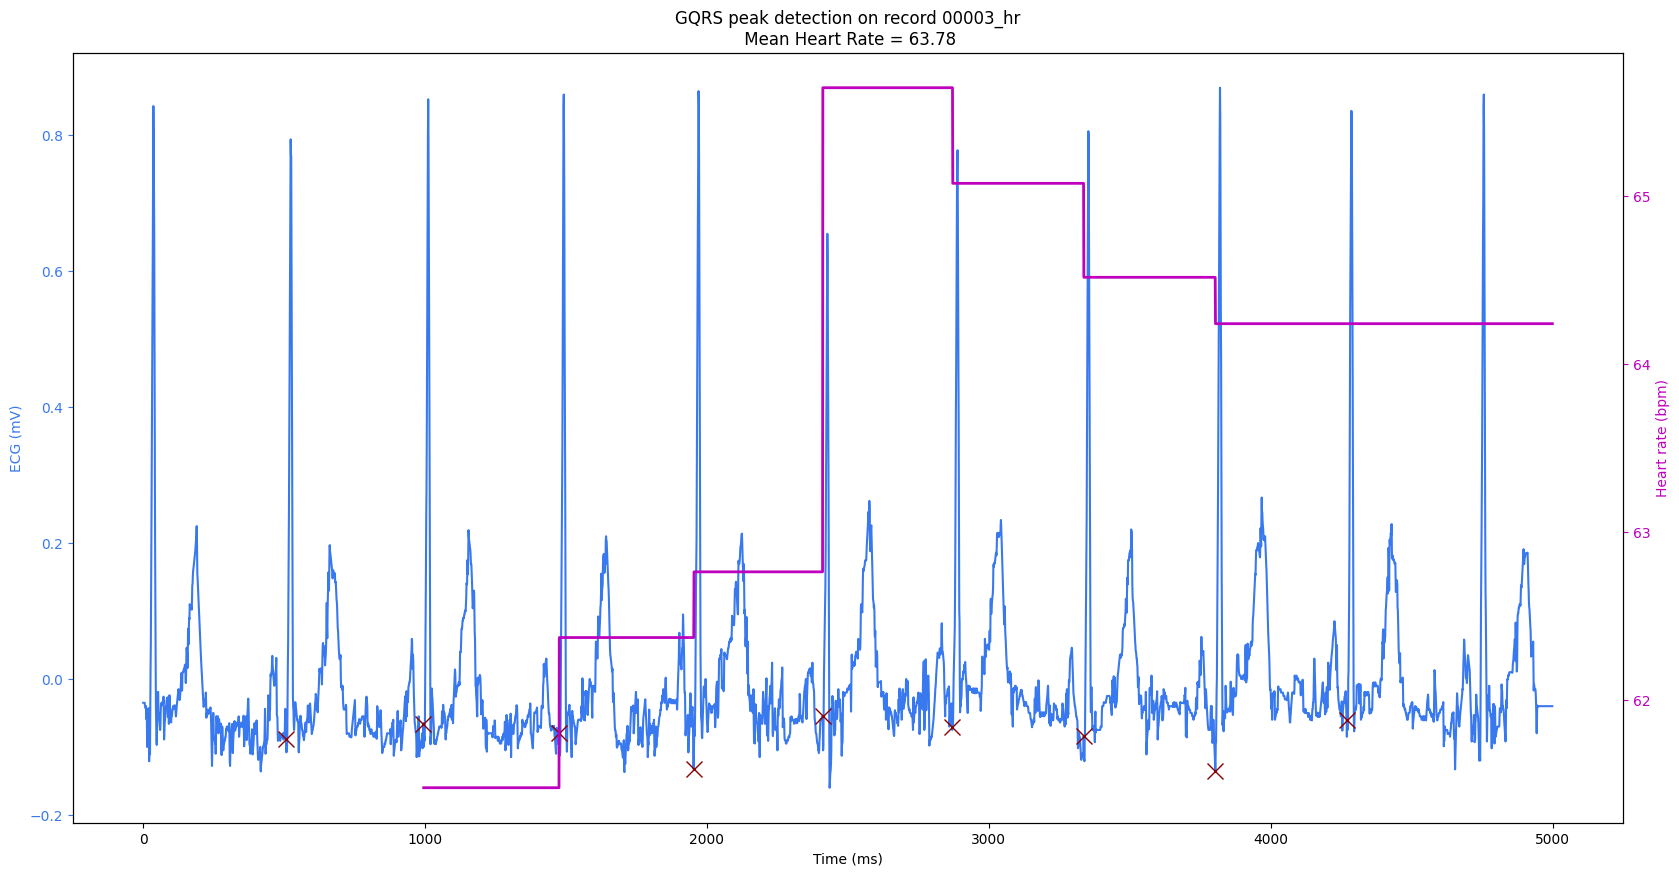

Corrected GQRS detected peak indices: [523, 1011, 1492, 1970, 2427, 2889, 3353, 3820, 4286]


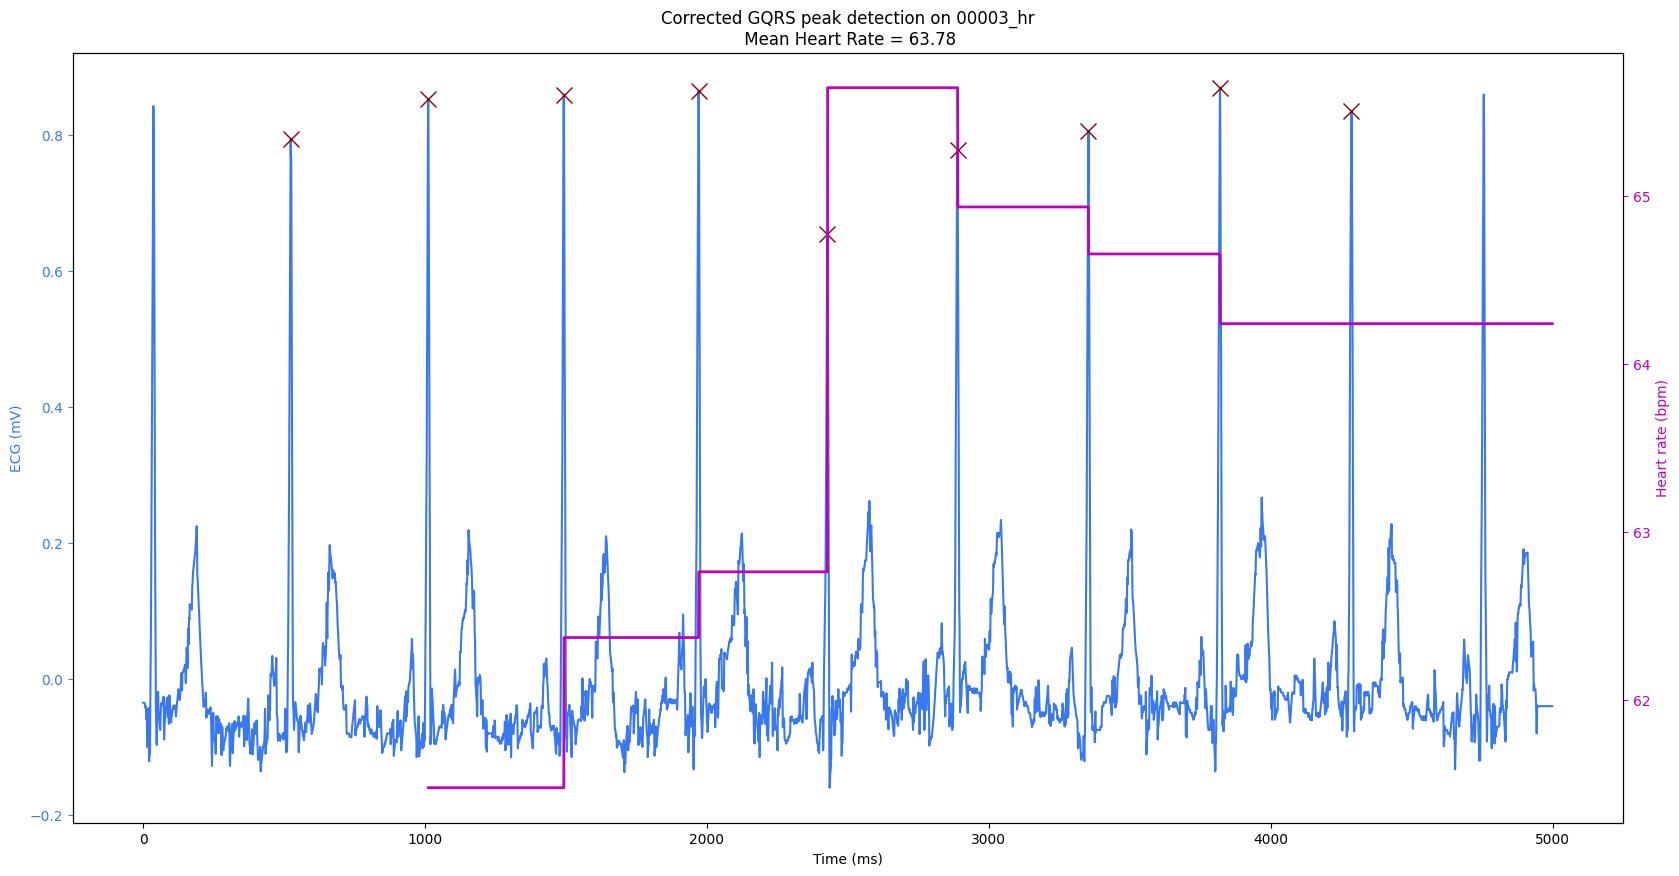

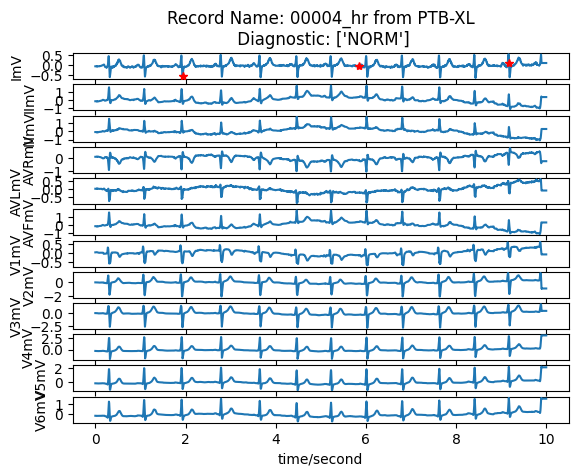

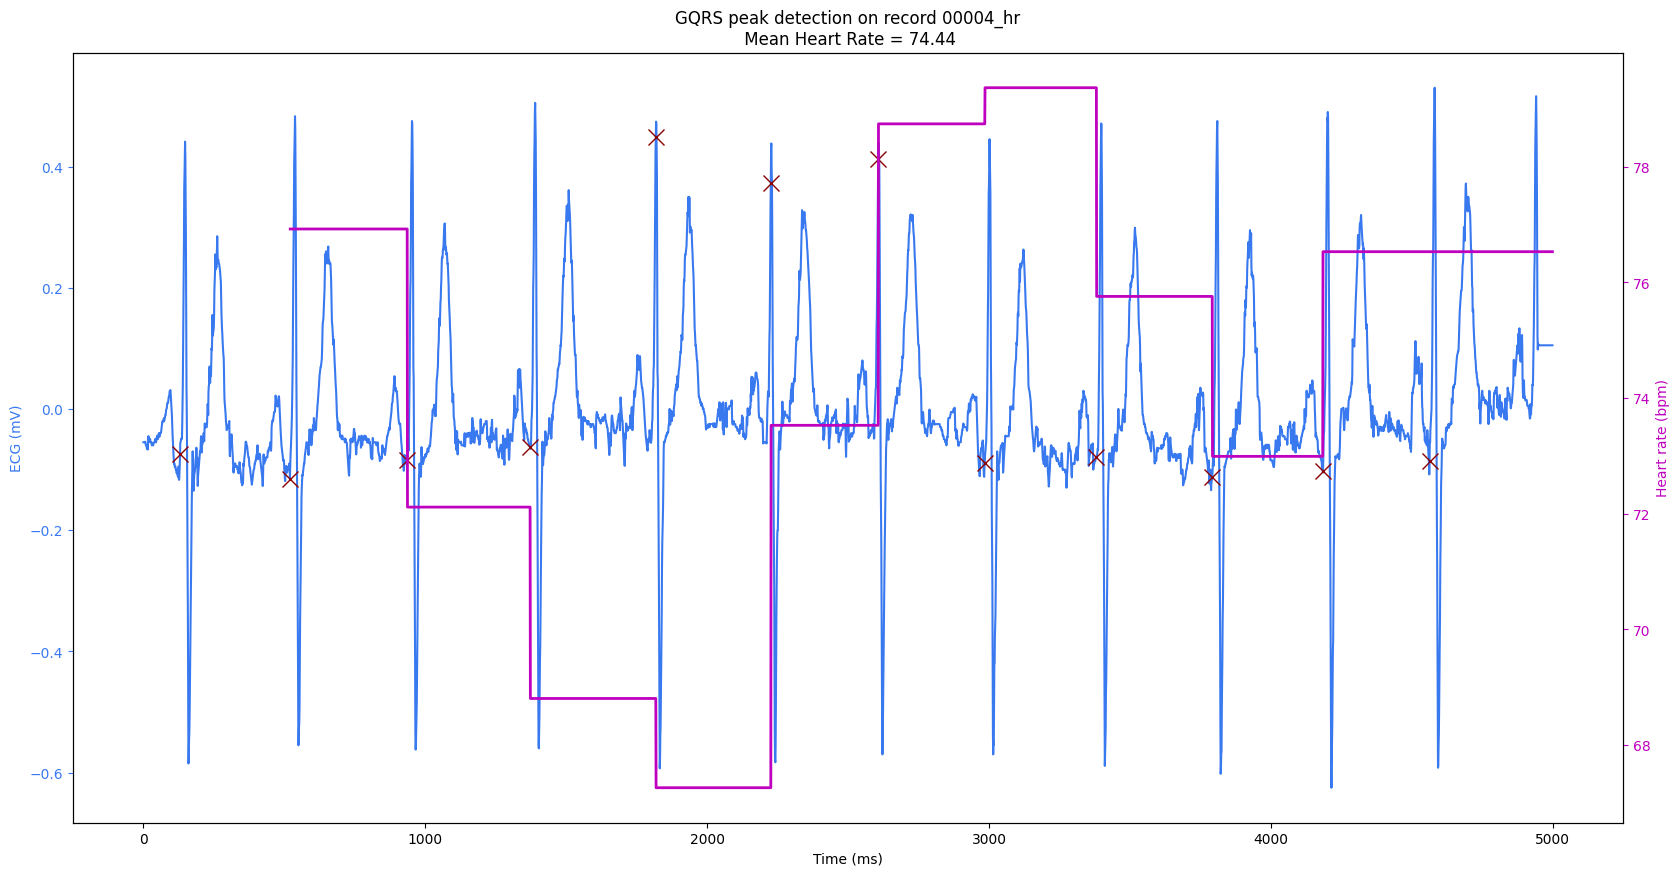

Corrected GQRS detected peak indices: [160, 550, 966, 1403, 1832, 2242, 2622, 3015, 3411, 3822, 4215, 4593]


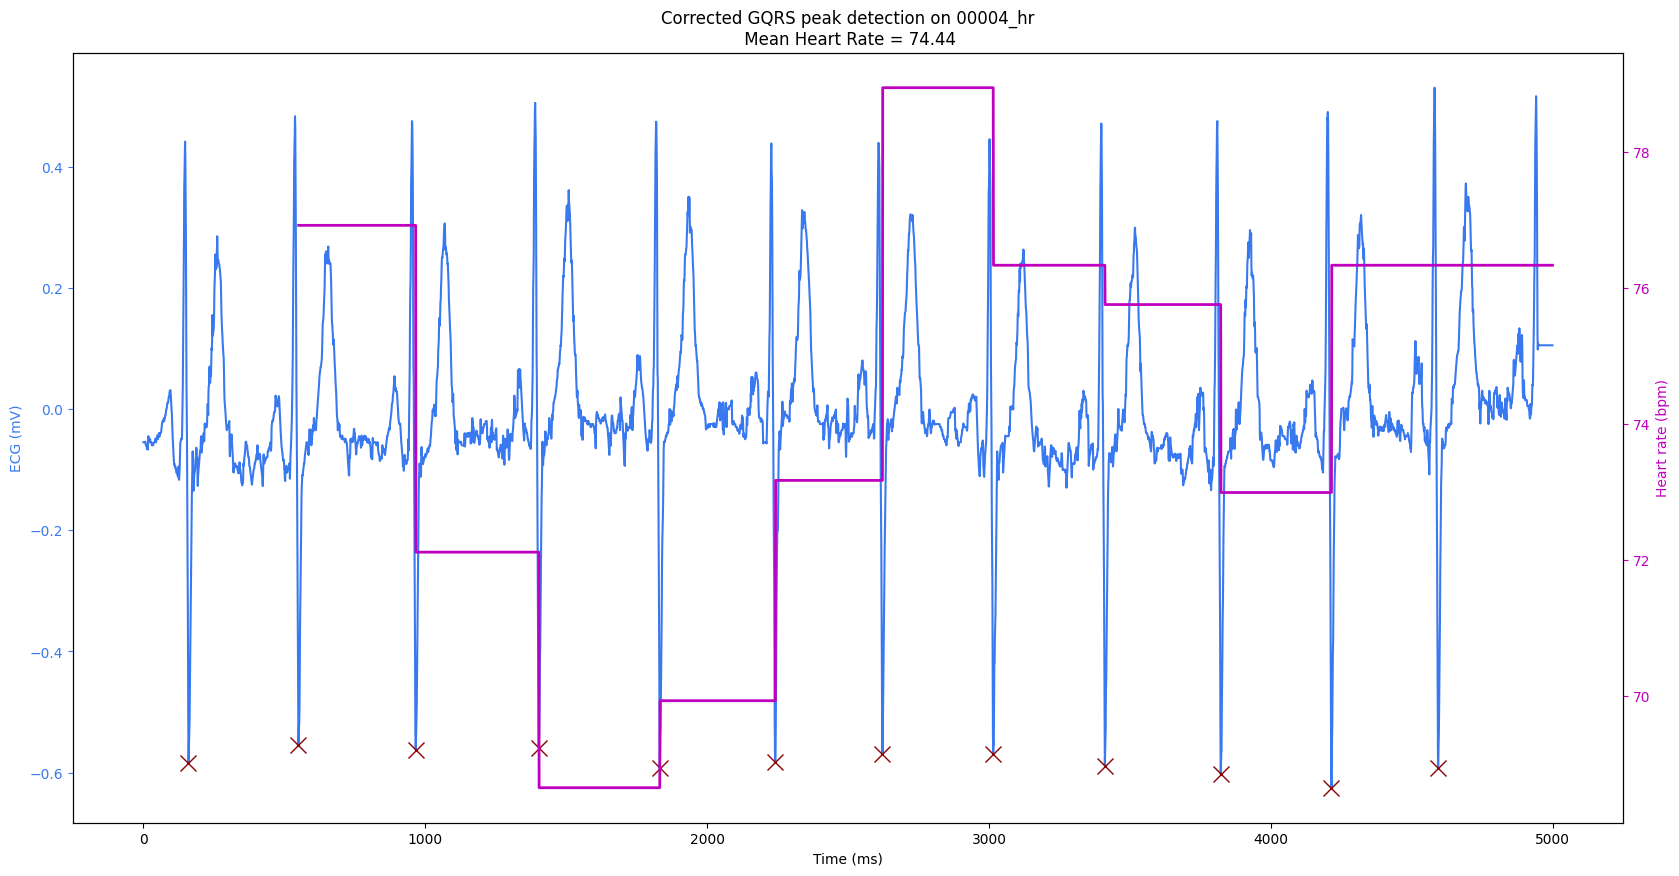

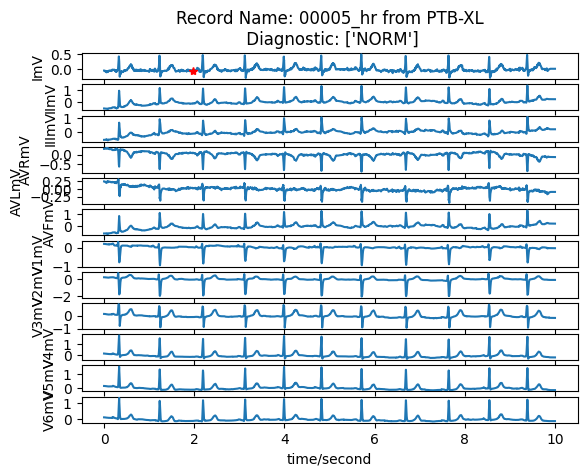

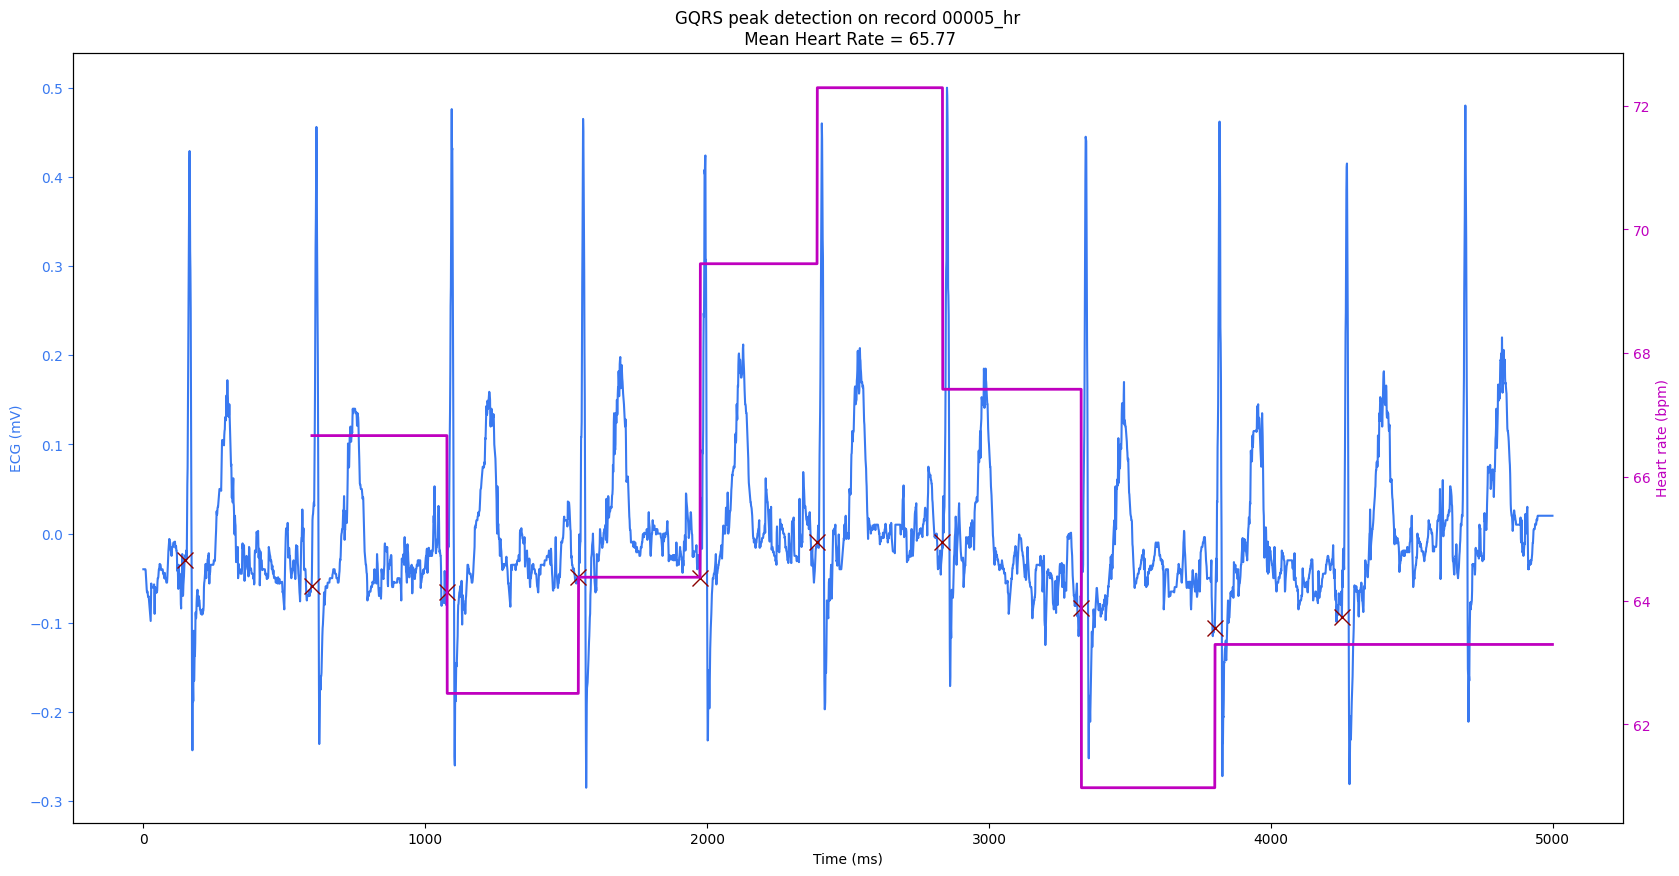

Corrected GQRS detected peak indices: [164, 614, 1094, 1560, 1994, 2407, 2851, 3343, 3818, 4270]


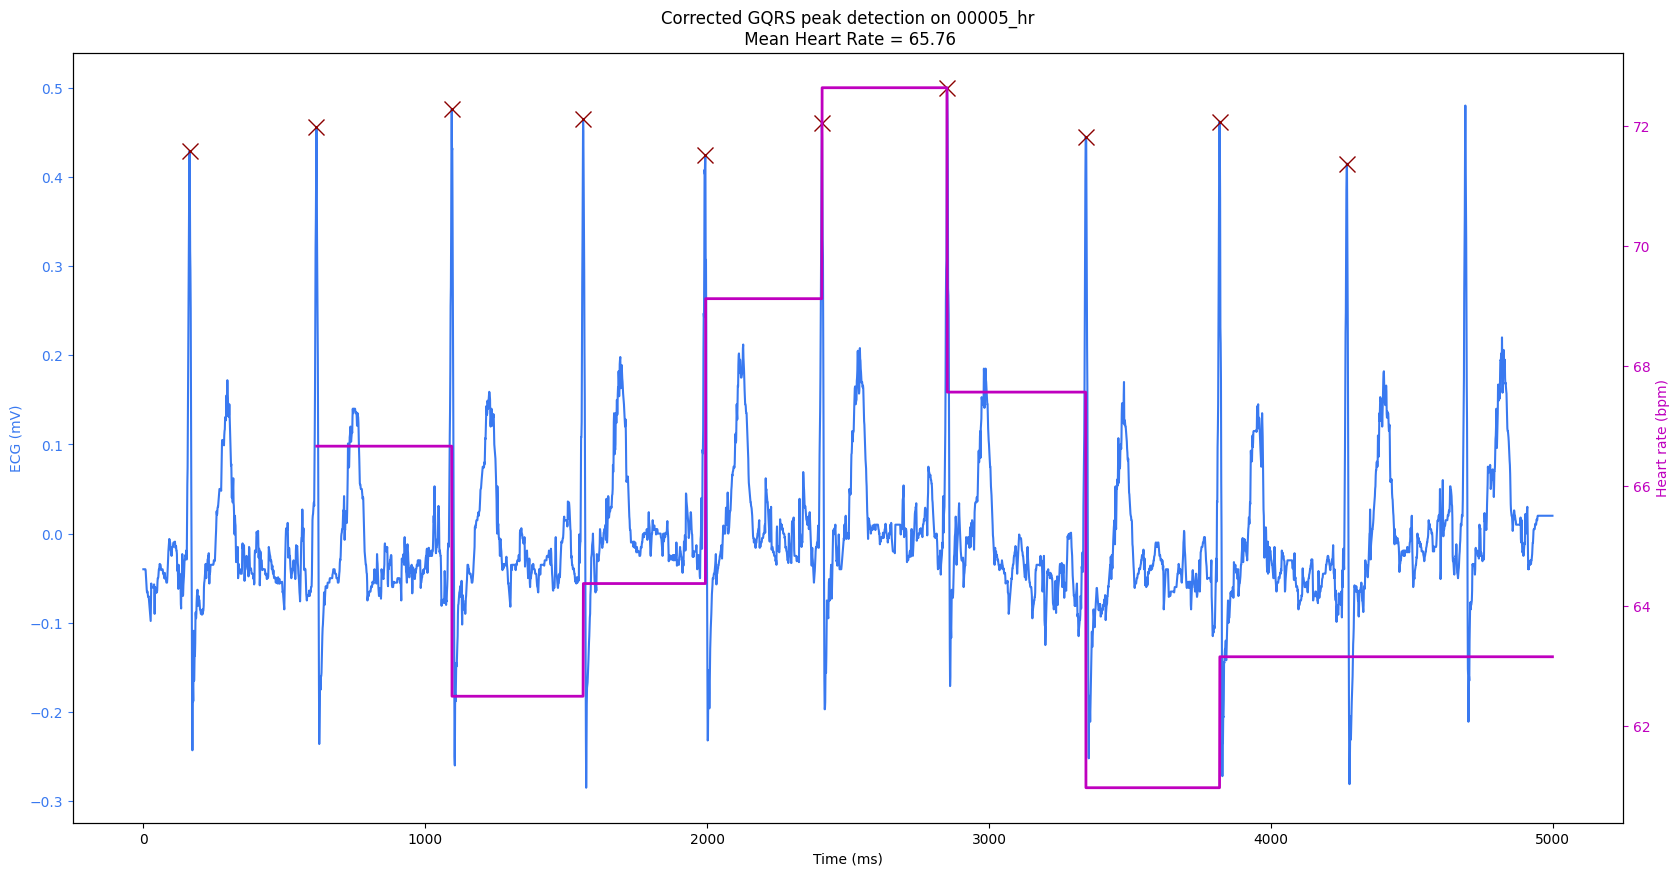

In [8]:
# Plot all channels, and the annotation on top of channel 0.
for i, (record, annotation) in enumerate(zip(records, annotations)):
    scp_codes = Y.iloc[i]['scp_codes']
    diagnostic_superclass = Y.iloc[i]['diagnostic_superclass']
    name = record.record_name

    if len(annotation.sample):
        wfdb.plot_wfdb(record=record, annotation=annotation,
                       title=f'Record Name: {name} from PTB-XL\n Diagnostic: {diagnostic_superclass}',
                       time_units='seconds')
    else:
        wfdb.plot_wfdb(record=record, annotation=None,
                       title=f'Record Name: {name} from PTB-XL\n Diagnostic: {diagnostic_superclass}',
                       time_units='seconds')

    qrs_inds = processing.gqrs_detect(record.p_signal[:,0], fs=record.fs)
    peaks_hr(sig=record.p_signal[:,0], peak_inds=qrs_inds, fs=record.fs,
             title=f"GQRS peak detection on record {name}")

    # Correct the peaks shifting them to local maxima
    min_bpm = 20
    max_bpm = 230

    # Use the maximum possible bpm as the search radius
    search_radius = int(record.fs * 60 / max_bpm)
    corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                        peak_inds=qrs_inds,
                                                        search_radius=search_radius, 
                                                        smooth_window_size=150)

    # Display results
    print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
    peaks_hr(sig=record.p_signal[:,0], peak_inds=sorted(corrected_peak_inds), fs=record.fs,
             title=f"Corrected GQRS peak detection on {name}")